In [11]:
## Install the package to deal with the unbalanced label classes problem
! pip install --upgrade pip
! pip install -U imbalanced-learn

Requirement already up-to-date: pip in /Users/benramdhan/anaconda/lib/python3.6/site-packages (19.0.3)
Requirement already up-to-date: imbalanced-learn in /Users/benramdhan/anaconda/lib/python3.6/site-packages (0.4.3)


In [12]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

# Oversampling Library 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# Plot librairies
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

In [13]:
#logger
def get_logger():
    FORMAT = '[%(levelname)s]%(asctime)s:%(name)s:%(message)s'
    logging.basicConfig(format=FORMAT)
    logger = logging.getLogger('main')
    logger.setLevel(logging.DEBUG)
    return logger

In [14]:
logger = get_logger()

In [15]:
def read_data(nrows=None):
    logger.info('Input data')
    train_df = pd.read_csv(os.getcwd() + '/train.csv',nrows=nrows)
    test_df = pd.read_csv(os.getcwd() + '/test.csv')
    return train_df, test_df

In [16]:
train_df, test_df = read_data(nrows=None)

[INFO]2019-03-12 19:10:22,265:main:Input data


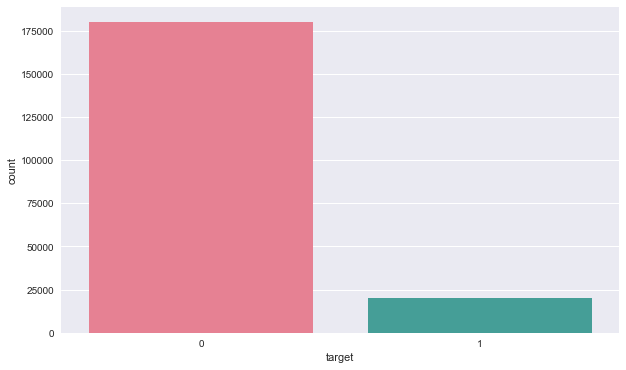

In [7]:
click_plot = sns.countplot(x='target', data = train_df, palette='husl')

In [8]:
# def process_data(train_df, test_df):
#     logger.info('Features engineering')
#     idx = [c for c in train_df.columns if c not in ['ID_code', 'target']]
#     enginering_feats = [('var_26','var_44'),('var_44','var_123'),('var_44','var_155')]
    
#     for df in [test_df, train_df]:
#         for feat in idx:
#             df['r2_'+feat] = np.round(df[feat], 2)
#         for fe_id, fe in enumerate(enginering_feats):
#             # Magic Feature Enginering
#             df = df_all.copy()
#             df['%s_plus_%s'%fe] = df[fe[0]]+df_e[fe[1]]
#             df['%s_minus_%s'%fe] = df[fe[1]]-df_e[fe[0]]
#             df.drop(list)
#         df['sum'] = df[idx].sum(axis=1)  
#         df['min'] = df[idx].min(axis=1)
#         df['max'] = df[idx].max(axis=1)
#         df['mean'] = df[idx].mean(axis=1)
#         df['std'] = df[idx].std(axis=1)
#         df['skew'] = df[idx].skew(axis=1)
#         df['kurt'] = df[idx].kurtosis(axis=1)
#         df['med'] = df[idx].median(axis=1)
#     print('Train and test shape:',train_df.shape, test_df.shape)
#     return train_df, test_df

In [17]:
def get_features_target(df):
    features = [c for c in df.columns if c not in ['ID_code', 'target']]
    target = df['target']
    return features, target

In [18]:
def run_model(train_df, test_df):
    logger.info('Prepare the model')
    features, target = get_features_target(train_df)
    logger.info('Run model')
    # Hyper-parameters 
    param = {
        'bagging_freq': 5,
        'bagging_fraction': 0.38,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.045,
        'learning_rate': 0.0095,
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': 80,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 13,
        'num_threads': 8,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1
    }
    num_round = 1000000
    folds = StratifiedKFold(n_splits=12, shuffle=False, random_state=44000)
    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
        print("Fold {}".format(fold_))
        # Oversampling with random replacement
        oversampled_features, oversampled_target = RandomOverSampler().fit_sample(train_df.iloc[trn_idx][features],
                                                                                  target.iloc[trn_idx])

        trn_data = lgb.Dataset(oversampled_features,
                               label=oversampled_target)
        val_data = lgb.Dataset(train_df.iloc[val_idx][features],
                               label=target.iloc[val_idx])
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=1000,
                        early_stopping_rounds = 3500)
        oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
        predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    score = roc_auc_score(target, oof)
    print("CV score: {:<8.5f}".format(score))
    return predictions, score

In [19]:
def submit(test_df, predictions, score):
    logger.info('Prepare submission')
    sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
    sub["target"] = predictions
    sub.to_csv("submission_{:<8.5f}.csv".format(score), index=False)

In [20]:
def read_process_train_submit(nrows=None):
    train_df, test_df = read_data(nrows)
    #train_df, test_df = process_data(train_df, test_df)
    predictions, score = run_model(train_df, test_df)
    submit(test_df, predictions, score)

In [ ]:
read_process_train_submit()

[INFO]2019-03-12 19:10:50,704:main:Input data
[INFO]2019-03-12 19:11:06,200:main:Prepare the model
[INFO]2019-03-12 19:11:06,201:main:Run model


Fold 0
Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.904626	valid_1's auc: 0.883476
[2000]	training's auc: 0.913833	valid_1's auc: 0.888999
[3000]	training's auc: 0.921008	valid_1's auc: 0.892558
[4000]	training's auc: 0.927175	valid_1's auc: 0.894819
[5000]	training's auc: 0.932626	valid_1's auc: 0.896705
[6000]	training's auc: 0.937535	valid_1's auc: 0.897822
[7000]	training's auc: 0.941982	valid_1's auc: 0.898587
[8000]	training's auc: 0.946186	valid_1's auc: 0.899025
[9000]	training's auc: 0.950115	valid_1's auc: 0.899448
[10000]	training's auc: 0.953785	valid_1's auc: 0.89967
[11000]	training's auc: 0.957232	valid_1's auc: 0.899636
[12000]	training's auc: 0.960449	valid_1's auc: 0.899837
[13000]	training's auc: 0.96338	valid_1's auc: 0.899891
[14000]	training's auc: 0.96619	valid_1's auc: 0.899829
[15000]	training's auc: 0.968716	valid_1's auc: 0.899709
[16000]	training's auc: 0.971094	valid_1's auc: 0.899646
Early stopping, best iteratio